In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score

In [15]:
# read in clean data
df = pd.read_csv('clean_imdb_2.csv')
df.set_index('title', inplace=True)

In [16]:
df.head()

,year,rating,num_reviews,genre,certificate,num_episodes,actors,network,runtime,awards
title,,,,,,,,,,
Level Up,2012.0,4.3,897,Sci-Fi,TV-PG,36,Gaelan Connell,Cartoon Network,30.0,0.0
Behind the Scenes,2012.0,8.0,12,Comedy,Not Rated,68,Keith Stoller,Lost Angeles Films,90.0,0.0
Mama Drama,2012.0,5.9,28,Reality-TV,Not Rated,10,Missing,495 Productions,60.0,0.0
Oprah Prime,2012.0,4.5,212,Talk-Show,Not Rated,86,Oprah Winfrey,Harpo Productions,60.0,1.0
Gator Boys,2012.0,7.0,609,Reality-TV,Not Rated,36,Paul Bedard,Mike Mathis Productions,60.0,0.0


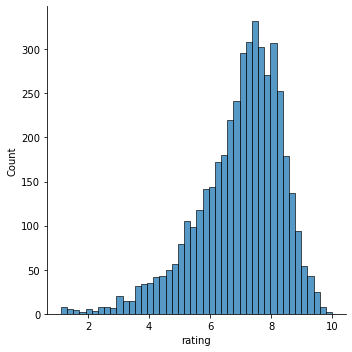

In [6]:
# target distribution 

sns.displot(df.rating)

Target distribution is a bit skewed

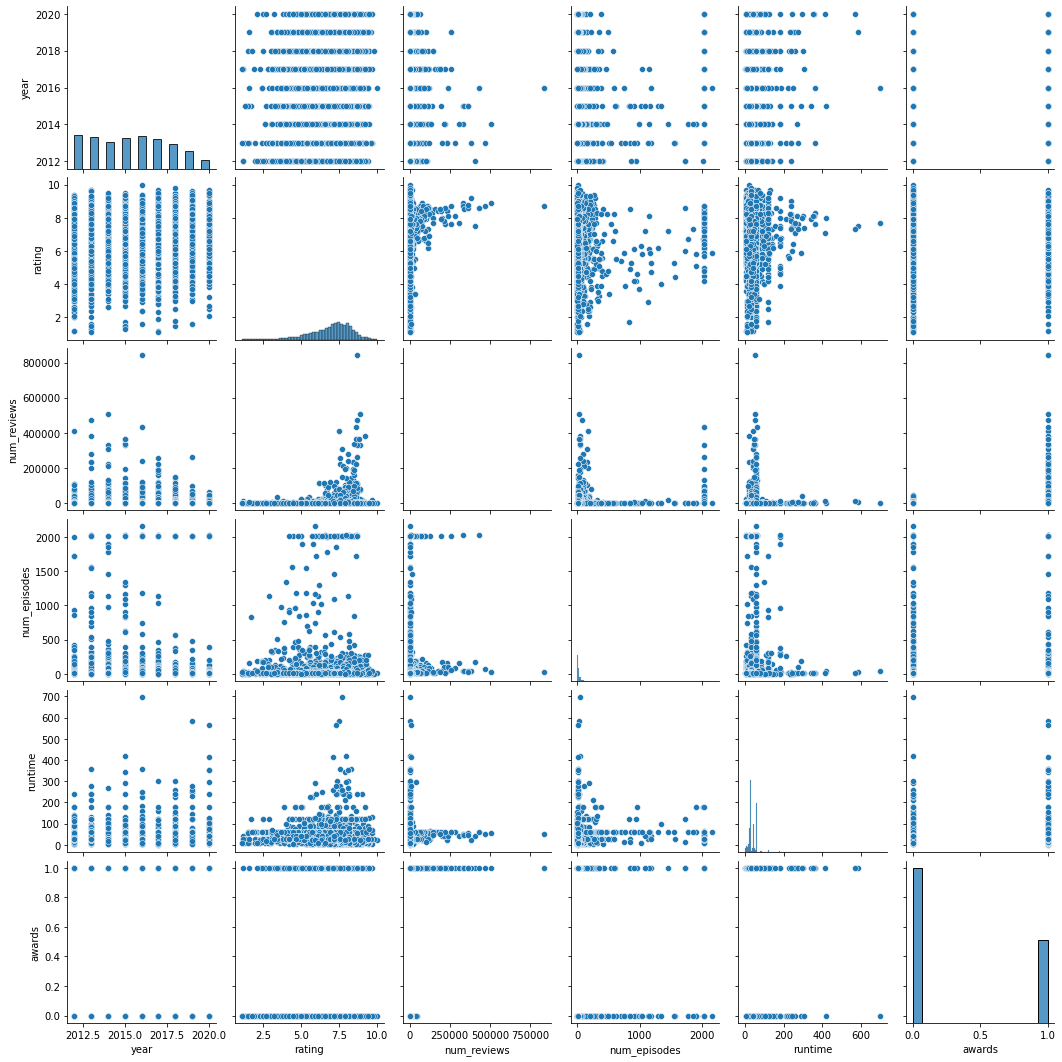

In [7]:
# check relationships between numeric features and target 

sns.pairplot(df)

In [8]:
# check correlations

df.corr()

,year,rating,num_reviews,num_episodes,runtime,awards
year,1.000000,0.022515,0.000526,0.043981,0.047228,0.075033
rating,0.022515,1.000000,0.131525,-0.011724,-0.004936,0.110483
num_reviews,0.000526,0.131525,1.000000,0.133838,0.039140,0.243369
num_episodes,0.043981,-0.011724,0.133838,1.000000,0.043015,0.123368
runtime,0.047228,-0.004936,0.039140,0.043015,1.000000,0.034635
awards,0.075033,0.110483,0.243369,0.123368,0.034635,1.000000


<AxesSubplot:>

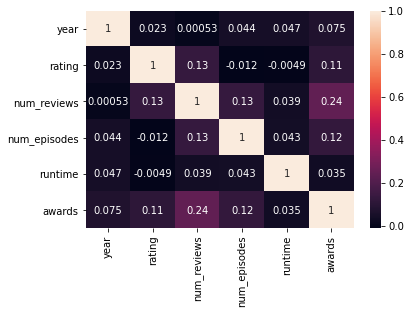

In [9]:
# plot heatmap
sns.heatmap(df.corr(), annot=True)

In [5]:
# check r2
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('rating ~ year + num_reviews + num_episodes + runtime + awards', data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     23.69
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           1.37e-23
Time:                        23:15:03   Log-Likelihood:                -7747.4
No. Observations:                4499   AIC:                         1.551e+04
Df Residuals:                    4493   BIC:                         1.555e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -14.5869     17.400     -0.838      0.402     -48.699      19.526
year             0.0106      0.009      1.233      0.218      -0.006       0.028
num_reviews   5.463e-06   7.19e-07      7.601      0.000    4.05e-06    6.87e-06
num_episodes    -0.0002   7.89e-05     -2.554      0.011      -0.000   -4.69e-05
runtime         -0.0005      0.001     -0.791      0.429      -0.002       0.001
awards           0.2473      0.044      5.620      0.000       0.161       0.334
==============================================================================
Omnibus:                      576.000   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              887.653
Skew:                          -0.912   Prob(JB):                    1.77e-193
Kurtosis:                       4.187   Cond. No.                     2.56e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

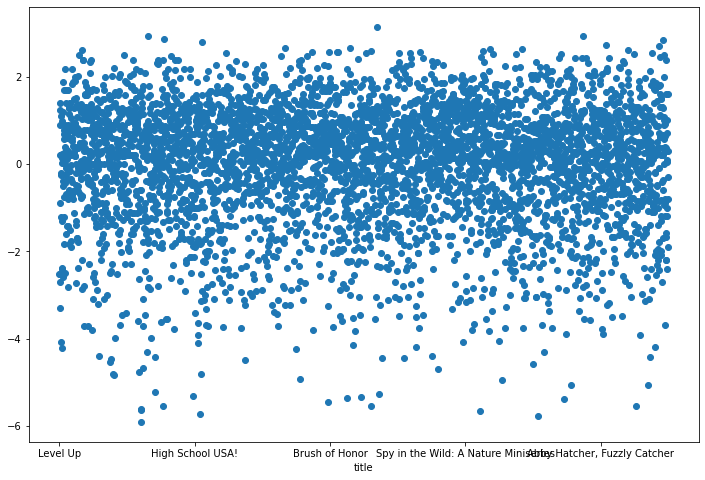

In [6]:
# plot residual
fit.resid.plot(style='o', figsize=(12,8));

Might have strong multicollinearity so need to use Ridge Regularization

In [17]:
# SIMPLE VALIDATION

def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=1)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

In [18]:
#Separate our numeric features from our target to create baseline model

X = df.loc[:,['year', 'awards', 'num_episodes', 
                      'runtime', 'num_reviews']]

y = df['rating']

In [19]:
split_and_validate(X, y)


Validation R^2 score was: 0.0195727505085298
Feature coefficient results: 

year : 0.01
awards : 0.26
num_episodes : -0.00
runtime : -0.00
num_reviews : 0.00


In [20]:
X.shape

(4499, 5)

Baseline R^2 score is 0.0196

In [21]:
# add polynomial terms
X2 = X.copy()

X2['num_reviews2'] = X2['num_reviews'] ** 2
X2['runtime2'] = X2['runtime'] ** 2
split_and_validate(X2, y)


Validation R^2 score was: 0.030104809726750226
Feature coefficient results: 

year : 0.01
awards : 0.21
num_episodes : -0.00
runtime : -0.00
num_reviews : 0.00
num_reviews2 : -0.00
runtime2 : 0.00


Increased R^2 to 0.03 

In [22]:
X3 = X2.copy()

X2['num_episodes2'] = X2['num_episodes'] ** 2
split_and_validate(X3, y)


Validation R^2 score was: 0.030104809726750226
Feature coefficient results: 

year : 0.01
awards : 0.21
num_episodes : -0.00
runtime : -0.00
num_reviews : 0.00
num_reviews2 : -0.00
runtime2 : 0.00


Changed terms for number of reviews, runtime, and number of episodes to 2, ,2 and 3

In [23]:
X4 = X3.copy()

# multiplicative interaction
X4['nr_x_awards'] = X4['num_reviews'] * X4['awards']

split_and_validate(X4, y)


Validation R^2 score was: 0.030125932768203523
Feature coefficient results: 

year : 0.01
awards : 0.21
num_episodes : -0.00
runtime : -0.00
num_reviews : 0.00
num_reviews2 : -0.00
runtime2 : 0.00
nr_x_awards : 0.00


NameError: name 'fit' is not defined

Increased R^2 by 0.00008

In [24]:
# trying 1 dummy variable

X5 = X4.copy()

X5['genre'] = df['genre']

split_and_validate(pd.get_dummies(X5), y)


Validation R^2 score was: 0.06943043219453382
Feature coefficient results: 

year : 0.00
awards : 0.15
num_episodes : -0.00
runtime : -0.00
num_reviews : 0.00
num_reviews2 : -0.00
runtime2 : 0.00
nr_x_awards : 0.00
genre_Action : 0.23
genre_Adventure : 0.38
genre_Animation : -0.93
genre_Biography : 0.67
genre_Comedy : -0.12
genre_Crime : 0.46
genre_Documentary : 0.29
genre_Drama : 0.21
genre_Family : -0.07
genre_Fantasy : -0.21
genre_Game-Show : -0.80
genre_History : 0.51
genre_Horror : -0.12
genre_Missing : 0.11
genre_Music : 0.00
genre_Musical : -0.40
genre_Mystery : 0.14
genre_News : -0.81
genre_Reality-TV : -0.42
genre_Romance : -0.07
genre_Sci-Fi : -0.50
genre_Short : 0.13
genre_Sport : 0.64
genre_Talk-Show : -0.17
genre_Thriller : -0.05
genre_War : 0.36
genre_Western : 0.57


r^2 increased to 0.07 after adding genre

In [25]:
# adding certificate dummy variable

X6 = X5.copy()

X6['certificate'] = df['certificate']

split_and_validate(pd.get_dummies(X6), y)


Validation R^2 score was: 0.07453388096792668
Feature coefficient results: 

year : 0.01
awards : 0.28
num_episodes : -0.00
runtime : -0.00
num_reviews : 0.00
num_reviews2 : -0.00
runtime2 : 0.00
nr_x_awards : -0.00
genre_Action : 0.11
genre_Adventure : 0.29
genre_Animation : -0.87
genre_Biography : 0.65
genre_Comedy : -0.13
genre_Crime : 0.47
genre_Documentary : 0.30
genre_Drama : 0.19
genre_Family : -0.06
genre_Fantasy : -0.09
genre_Game-Show : -0.81
genre_History : 0.52
genre_Horror : -0.16
genre_Missing : 0.03
genre_Music : 0.05
genre_Musical : -0.33
genre_Mystery : 0.22
genre_News : -0.91
genre_Reality-TV : -0.44
genre_Romance : -0.06
genre_Sci-Fi : -0.40
genre_Short : 0.15
genre_Sport : 0.60
genre_Talk-Show : -0.23
genre_Thriller : -0.03
genre_War : 0.33
genre_Western : 0.60
certificate_12 : 0.06
certificate_Approved : -1.05
certificate_E : 0.72
certificate_G : 1.10
certificate_M : -0.58
certificate_Not Rated : 0.24
certificate_Not Rated Not Rated : 0.08
certificate_PG : 0.57
ce

r2 increased to 0.075

In [37]:
# adding actor dummy variable
actors_counts = df.actors.value_counts()
only_1_show = list(actors_counts[actors_counts < 2].index)

X7 = X6.copy()
X7['actors'] = df['actors'].replace(only_1_show, 'not_popular')

split_and_validate(pd.get_dummies(X7), y)


Validation R^2 score was: -0.008937106892807689
Feature coefficient results: 

year : 0.01
awards : 0.33
num_episodes : -0.00
runtime : -0.00
num_reviews : 0.00
num_reviews2 : -0.00
runtime2 : 0.00
num_episodes2 : 0.00
nr_x_awards : -0.00
genre_Action : 0.09
genre_Adventure : 0.17
genre_Animation : -1.07
genre_Biography : 0.78
genre_Comedy : -0.09
genre_Crime : 0.45
genre_Documentary : 0.19
genre_Drama : 0.16
genre_Family : -0.01
genre_Fantasy : -0.13
genre_Game-Show : -0.83
genre_History : 0.52
genre_Horror : -0.18
genre_Missing : 0.00
genre_Music : 0.21
genre_Musical : -0.17
genre_Mystery : 0.25
genre_News : -0.65
genre_Reality-TV : -0.45
genre_Romance : -0.03
genre_Sci-Fi : -0.46
genre_Short : 0.15
genre_Sport : 0.60
genre_Talk-Show : -0.14
genre_Thriller : -0.06
genre_War : 0.21
genre_Western : 0.48
certificate_12 : 0.26
certificate_Approved : -1.21
certificate_E : 2.30
certificate_G : 1.24
certificate_M : -0.71
certificate_Not Rated : 0.13
certificate_Not Rated Not Rated : -0.05


R2 IS NOW NEGATIVE. WILL DO CROSS VALIDATION